# Goal

This notebook loads in the Bister and Emanuel (2002, BE02) sample data and MATLAB algorithm PI calculations, calculates and clocks the PI calculation with the pi.py module (pyPI), and then validates/compares the datasets.

In [1]:
import sys
sys.path.append(sys.path[0]+'/..')
import numpy as np
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import time
# load PI calculation module
from pi import pi

In [2]:
# change default figure font settings
font = {'family' : 'sans-serif',
        'weight' : 1,
        'size'   : 16}

matplotlib.rc('font', **font)

# Load Data

In [3]:
# data location
dat_loc='../data/sample_data.nc'
# load and view netcdf file
ds = xr.open_dataset(dat_loc)
ds

<xarray.Dataset>
Dimensions:  (lat: 73, lon: 144, month: 12, p: 31)
Coordinates:
  * p        (p) float64 1e+03 975.0 950.0 925.0 900.0 ... 40.0 30.0 20.0 10.0
  * lat      (lat) float64 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
  * lon      (lon) float64 -180.0 -177.5 -175.0 -172.5 ... 172.5 175.0 177.5
  * month    (month) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0
Data variables:
    lsm      (lat, lon) float64 ...
    sst      (month, lat, lon) float64 ...
    msl      (month, lat, lon) float64 ...
    t        (month, p, lat, lon) float64 ...
    q        (month, p, lat, lon) float64 ...
    Vmax     (month, lat, lon) float64 ...
    To       (month, lat, lon) float64 ...
    Pmin     (month, lat, lon) float64 ...
    LNB      (month, lat, lon) float64 ...
    PI_flag  (month, lat, lon) float64 ...

In [4]:
# store the data in numpy arrays
SST,MSL,Ta,R,P=np.asarray(ds.sst),np.asarray(ds.msl),np.asarray(ds.t),np.asarray(ds.q),np.asarray(ds.p)

# Calculate PI with Python module

In [5]:
# find the sizes of the the arrays
nlat,nlon=ds.sst.sizes['lat'],ds.sst.sizes['lon']
# create arrays to store data
VMAXp,PMINp,TOp,LNBp=np.zeros((12,nlat,nlon),dtype='float64'),np.zeros((12,nlat,nlon),dtype='float64'), \
    np.zeros((12,nlat,nlon),dtype='float64'),np.zeros((12,nlat,nlon),dtype='float64')
IFLp=np.zeros((12,nlat,nlon),dtype='float64')
# fill with missing data
VMAXp[:],PMINp[:],TOp[:],LNBp[:],IFLp[:]=np.nan,np.nan,np.nan,np.nan,np.nan
# (VMAX,PMIN,IFL,TO,LNB)=pi(sst1,msl1,p1,t1,q1,CKCD=0.9,ascent_flag=0,diss_flag=1,V_reduc=0.8)

In [6]:
# time the loop
start = time.time()

# loop over the data grid and calculate PI
for m in range(12):
    for x in range(nlon):
        for y in range(nlat):
            if (SST[m,y,x]>0.0):
                (VMAXp[m,y,x],PMINp[m,y,x],IFLp[m,y,x],TOp[m,y,x],LNBp[m,y,x]) = pi( \
                    SST[m,y,x],MSL[m,y,x],P,Ta[m,:,y,x],R[m,:,y,x],\
                    CKCD=0.9,ascent_flag=0,diss_flag=1,V_reduc=0.8,miss_handle=1)
                
            
    

end = time.time()
print(end - start)

19.558465719223022


# Compare Python output to MATLAB output

To validate the output of the pi.py module, we compare it with the MATLAB calculated Potential Intensity code output (provided in the sample_data.nc file). We explore the absolute differences, correlations, and the temporal/spatial structures.

## Potential Intensity Maximum Wind (VMAX)

In [7]:
# calculate the difference between Python and MATLAB
diff_VMAX=VMAXp-ds.Vmax

In [8]:
print('VMAX: The maximum absolute difference across all points is '+str(float(abs(diff_VMAX).max())))

VMAX: The maximum absolute difference across all points is 4.109456969558778e-05


#### Spatial Structure

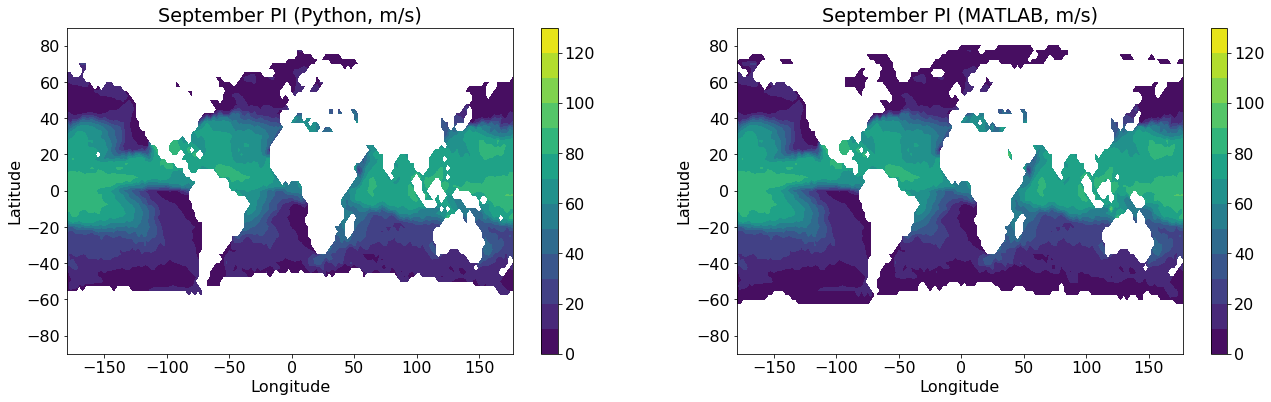

In [9]:
# plot both side by side in September
clevels=np.arange(0,140,10)
plt.figure(figsize=(22,6))
plt.subplot(1,2,1)
plt.contourf(ds.lon,ds.lat,VMAXp[8,:,:],clevels)
plt.xlabel(ds.lon.standard_name)
plt.ylabel(ds.lat.standard_name)
plt.title('September PI (Python, m/s)')
plt.colorbar()

plt.subplot(1,2,2)
plt.contourf(ds.lon,ds.lat,ds.Vmax.isel(month=8),clevels)
plt.xlabel(ds.lon.standard_name)
plt.ylabel(ds.lat.standard_name)
plt.title('September PI (MATLAB, m/s)')
plt.colorbar()
plt.show()

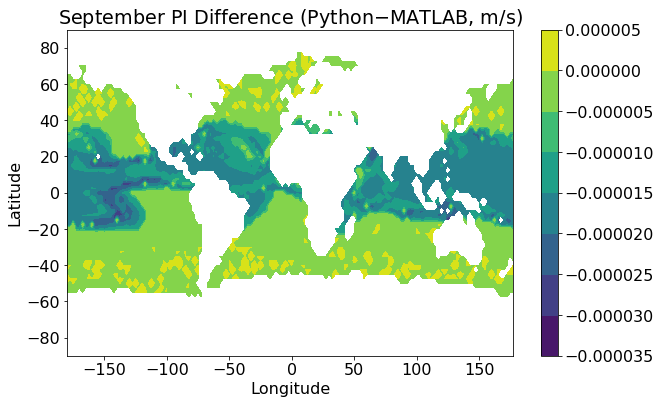

In [10]:
plt.figure(figsize=(10,6))
plt.contourf(ds.lon,ds.lat,diff_VMAX.isel(month=8))
plt.xlabel(ds.lon.standard_name)
plt.ylabel(ds.lat.standard_name)
plt.title('September PI Difference (Python$-$MATLAB, m/s)')
plt.colorbar()
plt.show()

#### Temporal Structure

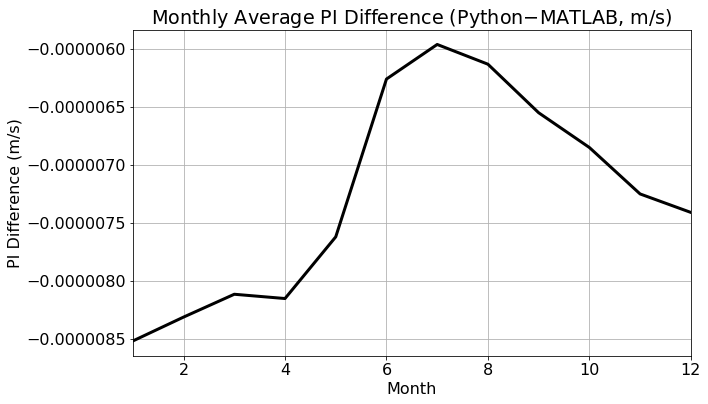

In [11]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(12)+1,diff_VMAX.mean(dim=['lat','lon']),color='k',lw=3)
plt.xlabel(ds.month.standard_name)
plt.ylabel('PI Difference (m/s)')
plt.title('Monthly Average PI Difference (Python$-$MATLAB, m/s)')
plt.grid()
plt.xlim([1,12])
plt.show()

#### Correlation Structure

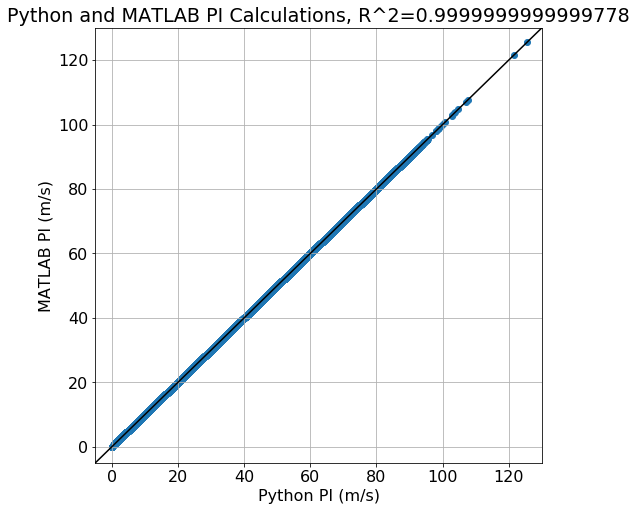

In [12]:
x1=VMAXp[:].flatten()[~np.isnan(VMAXp[:].flatten())]
x2=np.asarray(ds.Vmax)[:].flatten()[~np.isnan(VMAXp[:].flatten())]
R=np.ma.corrcoef(x1,x2)

plt.figure(figsize=(8,8))
plt.plot([-5,130],[-5,130],color='k')
plt.scatter(VMAXp,ds.Vmax)
plt.xlabel('Python PI (m/s)')
plt.ylabel('MATLAB PI (m/s)')
plt.title('Python and MATLAB PI Calculations, R^2='+str(R[0,1]**2))
plt.xlim([-5,130])
plt.ylim([-5,130])
plt.grid()
plt.show()

## Potential Intensity Minimum Pressure (PMIN)

In [13]:
# calculate the difference between Python and MATLAB
diff_PMIN=PMINp-ds.Pmin

In [14]:
print('PMIN: The maximum absolute difference across all points is '+str(float(abs(diff_PMIN).max())))

PMIN: The maximum absolute difference across all points is 0.0006777920652893954


#### Spatial Structure

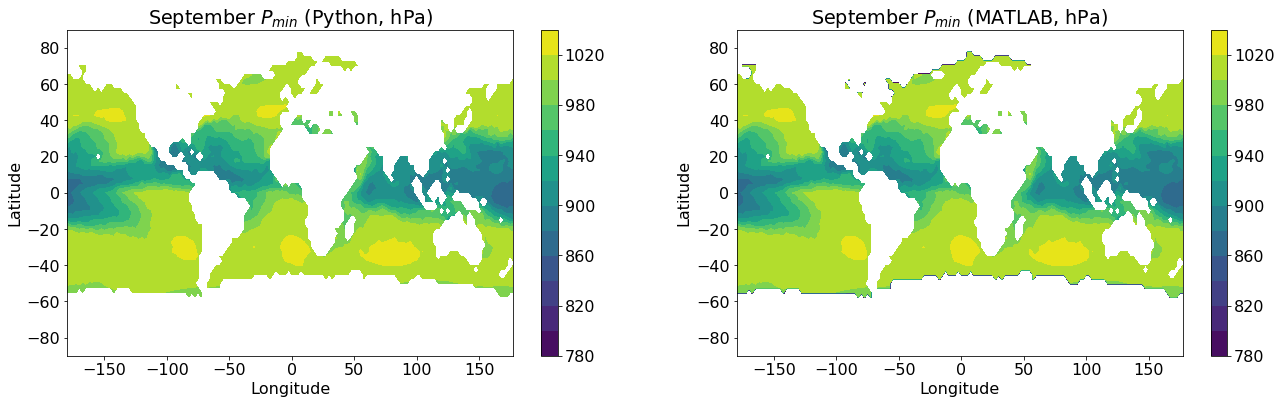

In [15]:
# plot both side by side in September
clevels=np.arange(780,1060,20)
plt.figure(figsize=(22,6))
plt.subplot(1,2,1)
plt.contourf(ds.lon,ds.lat,PMINp[8,:,:],clevels)
plt.xlabel(ds.lon.standard_name)
plt.ylabel(ds.lat.standard_name)
plt.title('September $P_{min}$ (Python, hPa)')
plt.colorbar()

plt.subplot(1,2,2)
plt.contourf(ds.lon,ds.lat,ds.Pmin.isel(month=8),clevels)
plt.xlabel(ds.lon.standard_name)
plt.ylabel(ds.lat.standard_name)
plt.title('September $P_{min}$ (MATLAB, hPa)')
plt.colorbar()
plt.show()

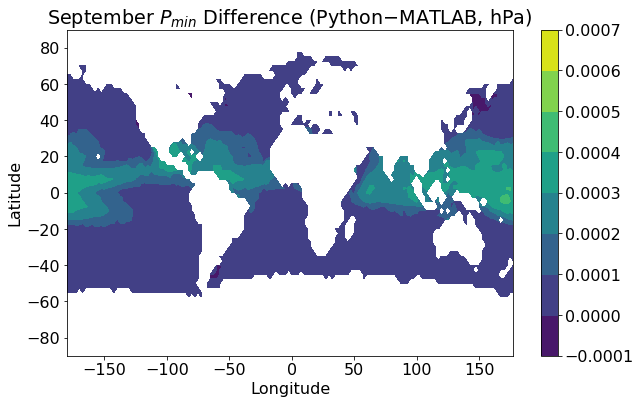

In [16]:
plt.figure(figsize=(10,6))
plt.contourf(ds.lon,ds.lat,diff_PMIN.isel(month=8))
plt.xlabel(ds.lon.standard_name)
plt.ylabel(ds.lat.standard_name)
plt.title('September $P_{min}$ Difference (Python$-$MATLAB, hPa)')
plt.colorbar()
plt.show()

#### Temporal Structure

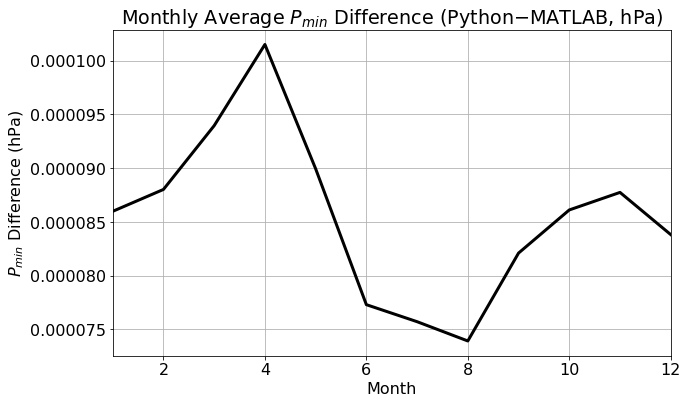

In [17]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(12)+1,diff_PMIN.mean(dim=['lat','lon']),color='k',lw=3)
plt.xlabel(ds.month.standard_name)
plt.ylabel('$P_{min}$ Difference (hPa)')
plt.title('Monthly Average $P_{min}$ Difference (Python$-$MATLAB, hPa)')
plt.grid()
plt.xlim([1,12])
plt.show()

#### Correlation Structure

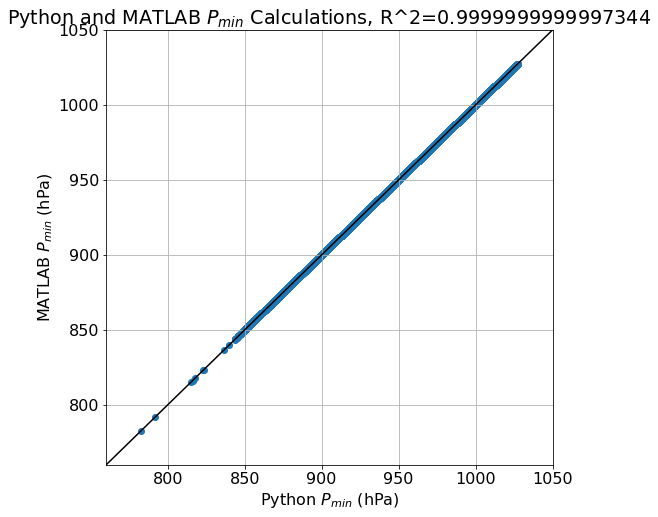

In [18]:
x1=PMINp[:].flatten()[~np.isnan(PMINp[:].flatten())]
x2=np.asarray(ds.Pmin)[:].flatten()[~np.isnan(PMINp[:].flatten())]
R=np.ma.corrcoef(x1,x2)

plt.figure(figsize=(8,8))
plt.plot([760,1050],[760,1050],color='k')
plt.scatter(PMINp,ds.Pmin)
plt.xlabel('Python $P_{min}$ (hPa)')
plt.ylabel('MATLAB $P_{min}$ (hPa)')
plt.title('Python and MATLAB $P_{min}$ Calculations, R^2='+str(R[0,1]**2))
plt.xlim([760,1050])
plt.ylim([760,1050])
plt.grid()
plt.show()

## Outflow Temperature

In [19]:
# calculate the difference between Python and MATLAB
diff_To=TOp-ds.To

In [20]:
print('T0: The maximum absolute difference across all points is '+str(float(abs(diff_To).max())))

T0: The maximum absolute difference across all points is 2.7938632541690822e-05


#### Spatial Structure

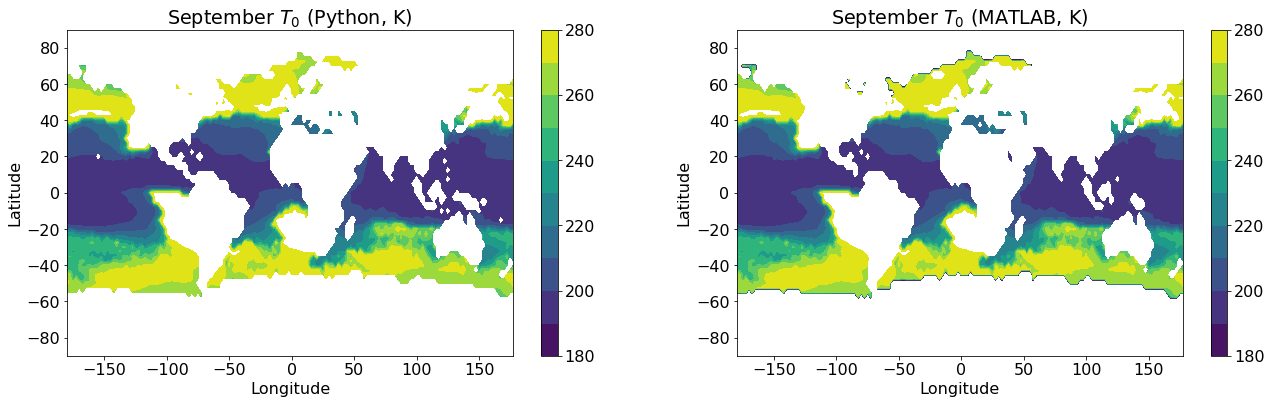

In [21]:
# plot both side by side in September
clevels=np.arange(180,290,10)
plt.figure(figsize=(22,6))
plt.subplot(1,2,1)
plt.contourf(ds.lon,ds.lat,TOp[8,:,:],clevels)
plt.xlabel(ds.lon.standard_name)
plt.ylabel(ds.lat.standard_name)
plt.title('September $T_{0}$ (Python, K)')
plt.colorbar()

plt.subplot(1,2,2)
plt.contourf(ds.lon,ds.lat,ds.To.isel(month=8),clevels)
plt.xlabel(ds.lon.standard_name)
plt.ylabel(ds.lat.standard_name)
plt.title('September $T_{0}$ (MATLAB, K)')
plt.colorbar()
plt.show()

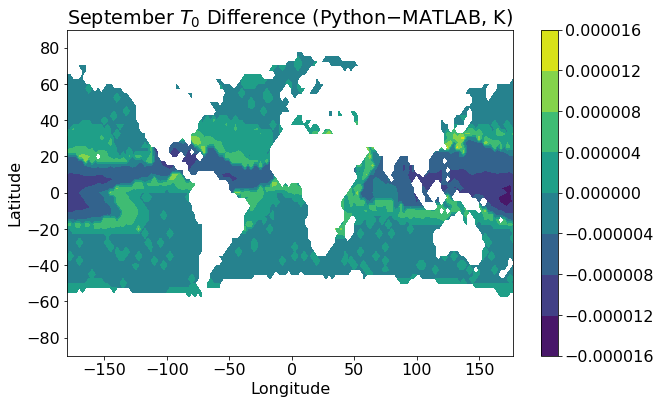

In [22]:
plt.figure(figsize=(10,6))
plt.contourf(ds.lon,ds.lat,diff_To.isel(month=8))
plt.xlabel(ds.lon.standard_name)
plt.ylabel(ds.lat.standard_name)
plt.title('September $T_{0}$ Difference (Python$-$MATLAB, K)')
plt.colorbar()
plt.show()

#### Temporal Structure

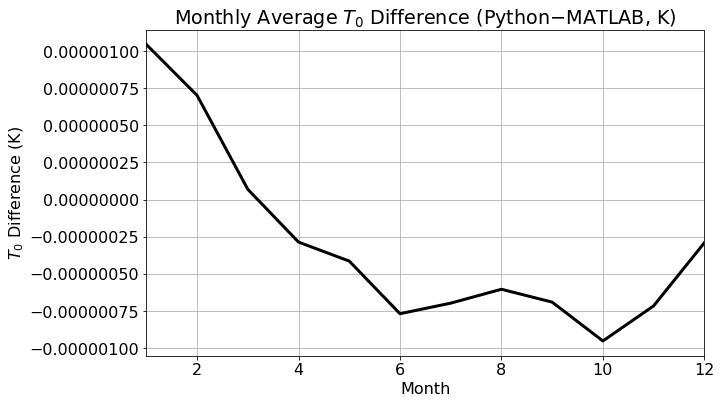

In [23]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(12)+1,diff_To.mean(dim=['lat','lon']),color='k',lw=3)
plt.xlabel(ds.month.standard_name)
plt.ylabel('$T_{0}$ Difference (K)')
plt.title('Monthly Average $T_{0}$ Difference (Python$-$MATLAB, K)')
plt.grid()
plt.xlim([1,12])
plt.show()

#### Correlation Structure

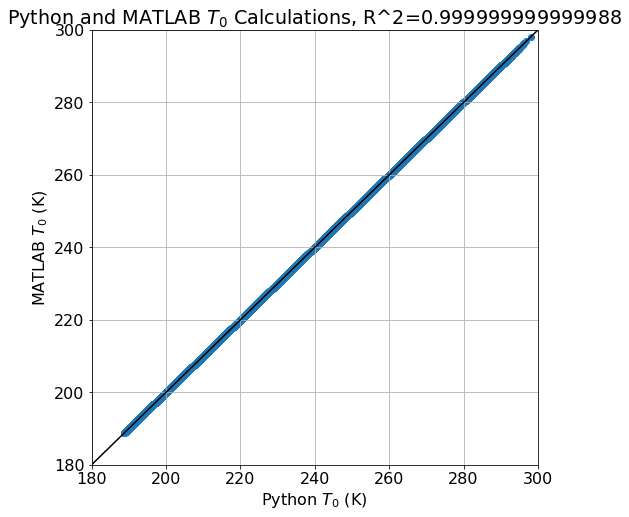

In [24]:
x1=TOp[:].flatten()[~np.isnan(TOp[:].flatten())]
x2=np.asarray(ds.To)[:].flatten()[~np.isnan(TOp[:].flatten())]
R=np.ma.corrcoef(x1,x2)

plt.figure(figsize=(8,8))
plt.plot([180,300],[180,300],color='k')
plt.scatter(TOp,ds.To)
plt.xlabel('Python $T_{0}$ (K)')
plt.ylabel('MATLAB $T_{0}$ (K)')
plt.title('Python and MATLAB $T_{0}$ Calculations, R^2='+str(R[0,1]**2))
plt.xlim([180,300])
plt.ylim([180,300])
plt.grid()
plt.show()

## Level of Neutral Buoyancy

In [25]:
# calculate the difference between Python and MATLAB
diff_LNB=LNBp-ds.LNB

In [26]:
print('LNB: The maximum absolute difference across all points is '+str(float(abs(diff_LNB).max())))

LNB: The maximum absolute difference across all points is 9.502328256871806e-05


#### Spatial Structure

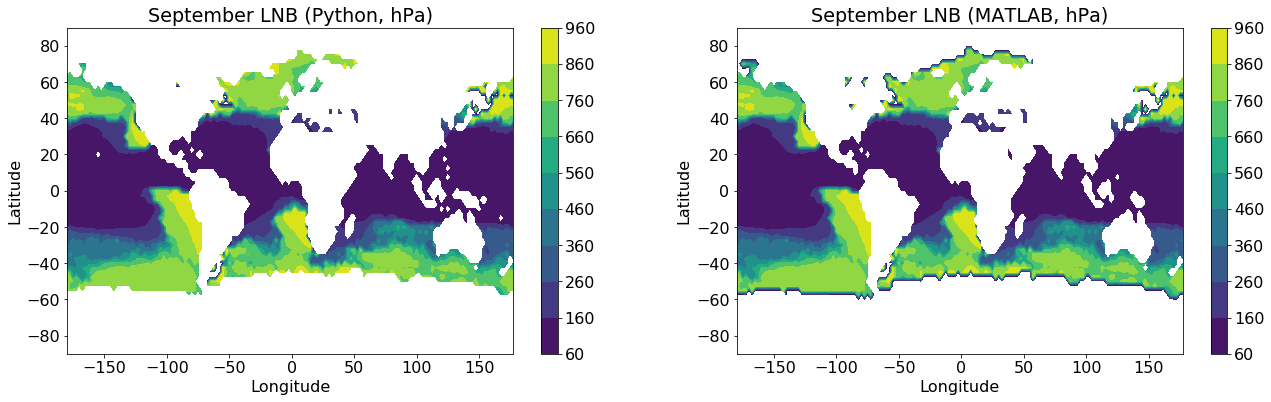

In [27]:
# plot both side by side in September
clevels=np.arange(60,1000,100)
plt.figure(figsize=(22,6))
plt.subplot(1,2,1)
plt.contourf(ds.lon,ds.lat,LNBp[8,:,:],clevels)
plt.xlabel(ds.lon.standard_name)
plt.ylabel(ds.lat.standard_name)
plt.title('September LNB (Python, hPa)')
plt.colorbar()

plt.subplot(1,2,2)
plt.contourf(ds.lon,ds.lat,ds.LNB.isel(month=8),clevels)
plt.xlabel(ds.lon.standard_name)
plt.ylabel(ds.lat.standard_name)
plt.title('September LNB (MATLAB, hPa)')
plt.colorbar()
plt.show()

/Users/dgilford/opt/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


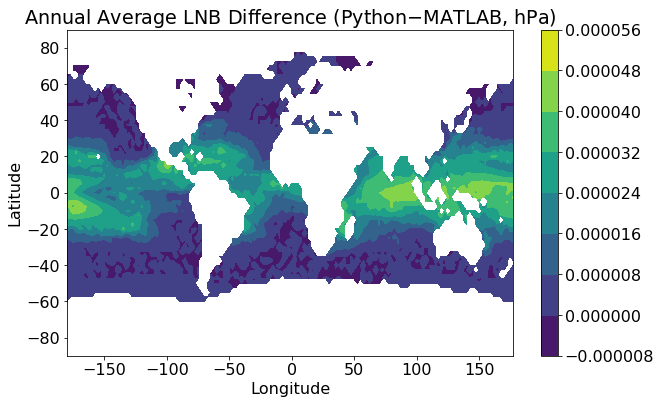

In [28]:
plt.figure(figsize=(10,6))
plt.contourf(ds.lon,ds.lat,diff_LNB.mean(['month']))
plt.xlabel(ds.lon.standard_name)
plt.ylabel(ds.lat.standard_name)
plt.title('Annual Average LNB Difference (Python$-$MATLAB, hPa)')
plt.colorbar()
plt.show()

#### Temporal Structure

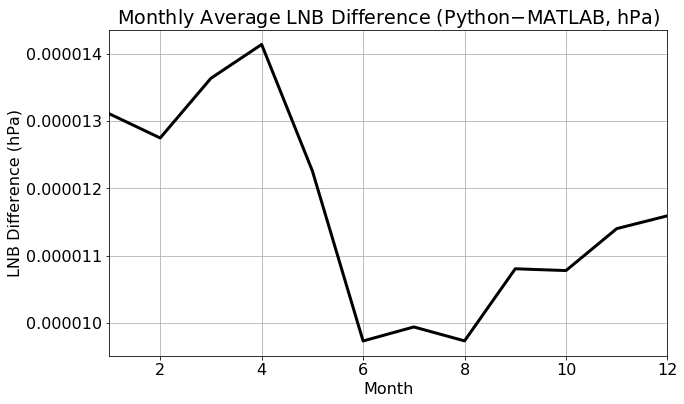

In [29]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(12)+1,diff_LNB.mean(dim=['lat','lon']),color='k',lw=3)
plt.xlabel(ds.month.standard_name)
plt.ylabel('LNB Difference (hPa)')
plt.title('Monthly Average LNB Difference (Python$-$MATLAB, hPa)')
plt.grid()
plt.xlim([1,12])
plt.show()

#### Correlation Structure

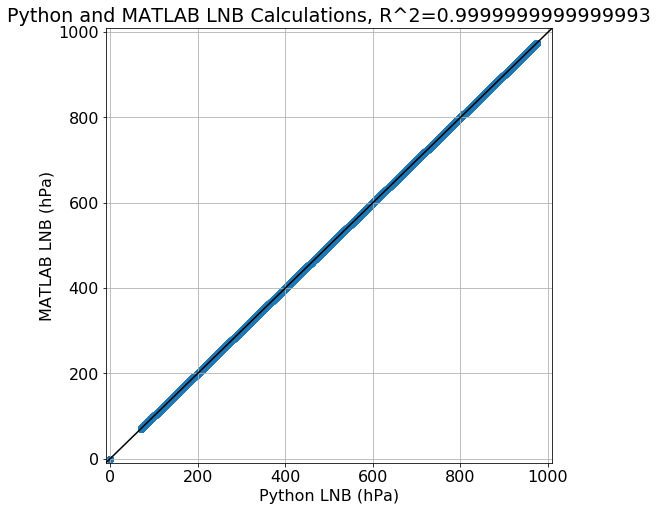

In [30]:
x1=LNBp[:].flatten()[~np.isnan(LNBp[:].flatten())]
x2=np.asarray(ds.LNB)[:].flatten()[~np.isnan(LNBp[:].flatten())]
R=np.ma.corrcoef(x1,x2)

plt.figure(figsize=(8,8))
plt.plot([-10,1010],[-10,1010],color='k')
plt.scatter(LNBp,ds.LNB)
plt.xlabel('Python LNB (hPa)')
plt.ylabel('MATLAB LNB (hPa)')
plt.title('Python and MATLAB LNB Calculations, R^2='+str(R[0,1]**2))
plt.xlim([-10,1010])
plt.ylim([-10,1010])
plt.grid()
plt.show()

## Flags

The average values of the differences in flags in not very meaningful. Instead, we need to examine the point-by-point differences.

#### Point-wise differences

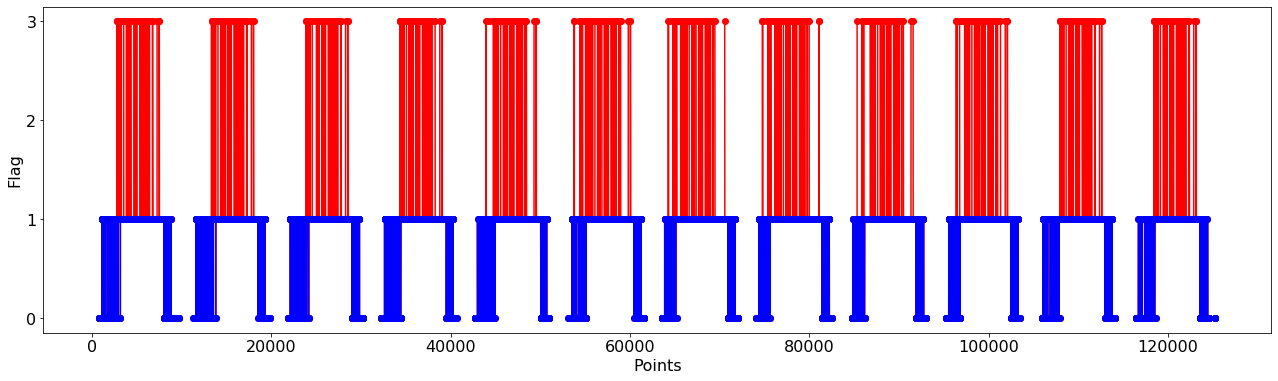

In [31]:
pflag=IFLp.flatten()
mflag=ds.PI_flag.values.flatten()
nflag=np.arange(len(mflag))
plt.figure(figsize=(22,6))
plt.plot(nflag,pflag,color='r',marker='o',label='PyPI')
plt.plot(nflag,mflag,color='b',marker='o',label='BE02 MATLAB')
plt.xlabel('Points')
plt.ylabel('Flag')
plt.yticks([0,1,2,3])
plt.show()

#### Spatial Structure

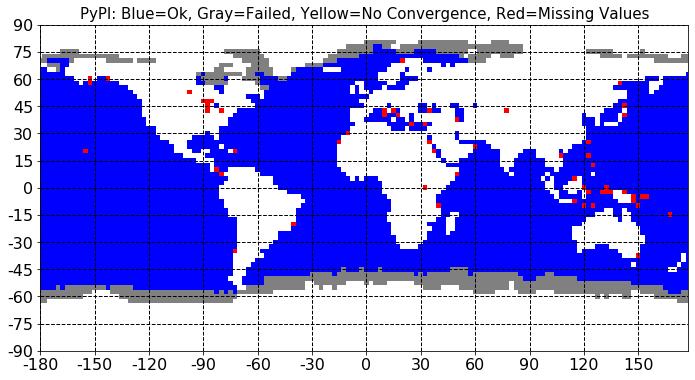

In [32]:
lonticks=(int(i) for i in ds.lon[0::12].values)
latticks=(int(i) for i in ds.lat[0::6].values)
from matplotlib import colors
cmap = colors.ListedColormap(['gray', 'blue', 'yellow', 'red'])
bounds = [0,1,2,3,4]
norm = colors.BoundaryNorm(bounds, cmap.N)

# plot both sets of flags in September
fig, ax = plt.subplots(figsize=(22,6))
ax.imshow(IFLp[8,:,:], cmap=cmap, norm=norm)

# draw gridlines
ax.grid(which='major', axis='both', color='k', linewidth=1, linestyle='--')
ax.set_xticks(np.arange(0, 144, 12))
ax.set_xticklabels(lonticks)
ax.set_yticks(np.arange(0, 73, 6))
ax.set_yticklabels(latticks)

ax.set_xlim([0,143])
ax.set_ylim([72,0])

plt.title('PyPI: Blue=Ok, Gray=Failed, Yellow=No Convergence, Red=Missing Values',fontsize=15)
plt.show()

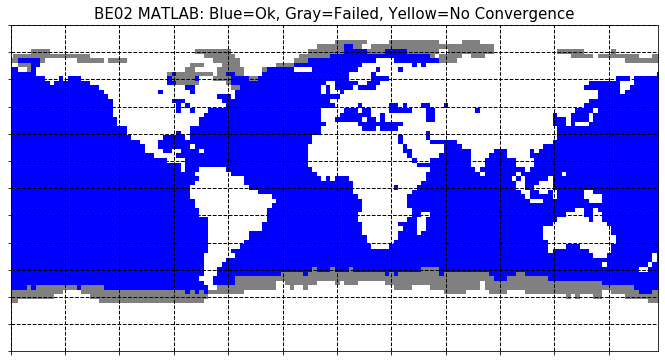

In [33]:
# plot both sets of flags in September
fig, ax = plt.subplots(figsize=(22,6))
ax.imshow(ds.PI_flag.isel(month=8), cmap=cmap, norm=norm)

# draw gridlines
ax.grid(which='major', axis='both', color='k', linewidth=1, linestyle='--')
ax.set_xticks(np.arange(0, 144, 12))
ax.set_xticklabels(lonticks)
ax.set_yticks(np.arange(0, 73, 6))
ax.set_yticklabels(latticks)

ax.set_xlim([0,143])
ax.set_ylim([72,0])

plt.title('BE02 MATLAB: Blue=Ok, Gray=Failed, Yellow=No Convergence',fontsize=15)
plt.show()

### Missing Data comparison

Related to these flags, we find the locations where either dataset has missing data and the other does not. This provides context on how the two scripts compare when they provide output.

In [34]:
pinvalidi=np.isnan(VMAXp)
VMAXm=np.asarray(ds.Vmax)
# note that Vmax==0 is identical to missing; account for this.
VMAXm[VMAXm==0]=np.nan
VMAXp[VMAXp==0]=np.nan
minvalidi=np.isnan(VMAXm)
print('Percent of NaN values in pyPI = '+str(np.sum(pinvalidi)/VMAXp.size*100)+'%')
print('Percent of NaN values in BE02 MATLAB = '+str(np.sum(minvalidi)/VMAXm.size*100)+'%')

Percent of NaN values in pyPI = 56.719304921359715%
Percent of NaN values in BE02 MATLAB = 57.51363521055302%


The difference between these percentages shows how many points differ in their missing data/NaN locations between pyPI and the BE02 MATLAB algorithm. Notably, pyPI compares favorably with the MATLAB code.

We can show the spatial locations of these extra NaN values...

In [35]:
VMAXm[minvalidi]=1e6
VMAXp[pinvalidi]=1e6

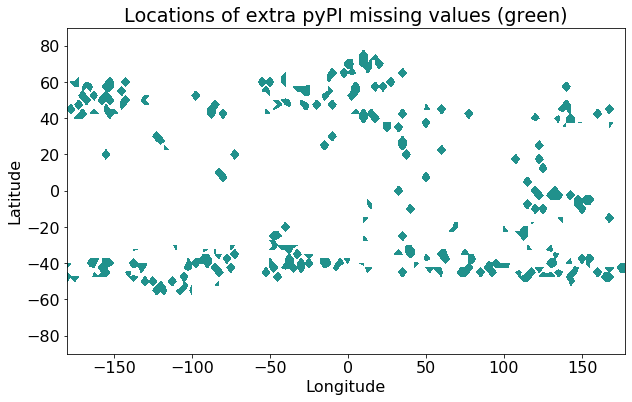

In [36]:
plt.figure(figsize=(10,6))
clevels=[0,1e7]
plt.contourf(ds.lon,ds.lat,VMAXp[8,:,:]-VMAXm[8,:,:],clevels)
plt.xlabel(ds.lon.standard_name)
plt.ylabel(ds.lat.standard_name)
plt.title('Locations of extra pyPI missing values (green)')
plt.show()

# Result

PI calculations with pyPI (specifically, the pi.py module) and MATLAB (from sample_data.nc) are strongly correlated. While there are differences in the flags and some locations where there is missing data (likely because PyPI restructures the way missing data is handled, see documentation), overall pyPI strongly matches the calculations of the MATLAB Bister and Emanuel (2002) function.